<a href="https://colab.research.google.com/github/Alimv81/emotion_detection_FER2012/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5121505365690804741
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17504017103180482219
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [24]:
import cv2
import zipfile
import numpy as np
import pandas as pd
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers, losses, optimizers
from keras import callbacks

In [25]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
url = "https://huggingface.co/spaces/mxz/emtion/resolve/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv"
df = pd.read_csv(url)

In [27]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [28]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [29]:
df_train = df[df['Usage']=='Training'].copy()
df_test = df[df['Usage']=='PublicTest'].copy()
df_valid = df[df['Usage']=='PrivateTest'].copy()

In [30]:
num_classes = 7
input_shape = (48, 48, 1)

def split_data(data):
  data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  images = np.array(data['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
  # images = np.repeat(images, 3, axis=-1) # to make the channels of the image into 3
  labels = data['emotion'].to_numpy()

  return images, labels

In [31]:
train_data, train_labels = split_data(df_train)
test_data, test_labels = split_data(df_test)
validation_data, validation_labels = split_data(df_valid)

In [56]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [114]:
model = Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.DepthwiseConv2D(kernel_size=(3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu'))
model.add(layers.UpSampling2D(size=(2, 2)))

model.add(layers.GlobalMaxPooling2D())

model.add(layers.SpatialDropout2D(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [115]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [116]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_22 (Ba  (None, 48, 48, 32)        128       
 tchNormalization)                                               
                                                                 
 separable_conv2d_2 (Separa  (None, 46, 46, 128)       4512      
 bleConv2D)                                                      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 23, 23, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 23, 23, 128)       0         
                                                      

In [117]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

In [118]:
history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=64),
    epochs=50,
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/50
449/449 [==============================] - 27s 46ms/step - loss: 2.1350 - accuracy: 0.2266 - val_loss: 2.1005 - val_accuracy: 0.1755 - lr: 0.0010
Epoch 2/50
  1/449 [..............................] - ETA: 25s - loss: 1.8898 - accuracy: 0.3438

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - 18s 40ms/step - loss: 1.6890 - accuracy: 0.3488 - val_loss: 1.8477 - val_accuracy: 0.3778 - lr: 0.0010
Epoch 3/50
449/449 [==============================] - 20s 44ms/step - loss: 1.4933 - accuracy: 0.4307 - val_loss: 1.4506 - val_accuracy: 0.4603 - lr: 0.0010
Epoch 4/50
449/449 [==============================] - 18s 41ms/step - loss: 1.3906 - accuracy: 0.4705 - val_loss: 1.3718 - val_accuracy: 0.4879 - lr: 0.0010
Epoch 5/50
449/449 [==============================] - 19s 42ms/step - loss: 1.3245 - accuracy: 0.4965 - val_loss: 1.2252 - val_accuracy: 0.5188 - lr: 0.0010
Epoch 6/50
449/449 [==============================] - 18s 41ms/step - loss: 1.2777 - accuracy: 0.5152 - val_loss: 1.2168 - val_accuracy: 0.5277 - lr: 0.0010
Epoch 7/50
449/449 [==============================] - 19s 42ms/step - loss: 1.2421 - accuracy: 0.5313 - val_loss: 1.3083 - val_accuracy: 0.5258 - lr: 0.0010
Epoch 8/50
449/449 [==============================] - 19s 42ms/step -

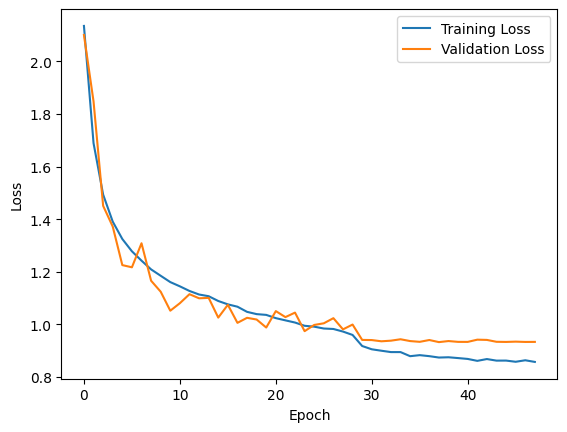

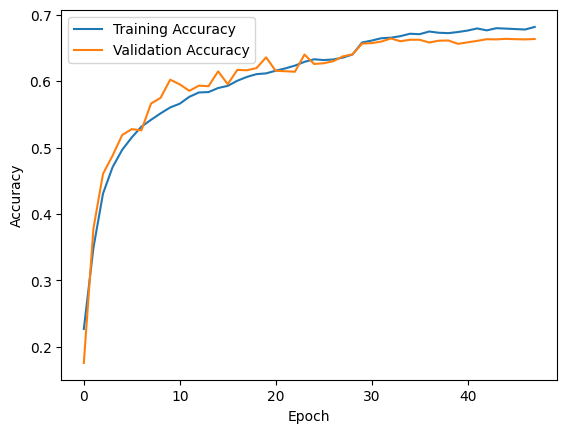

In [119]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [120]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [121]:
predy = model.predict(test_data)

113/113 [==============================] - 1s 4ms/step


In [122]:
predy[0], np.argmax(predy[0])

(array([0.7123198 , 0.11228828, 0.04259705, 0.00578138, 0.07912276,
        0.00474879, 0.04314191], dtype=float32),
 0)

In [132]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_labels, np.argmax(predy, axis=1)))

0.6483700195040402


In [133]:
idx = [9, 184, 1348, 2834]
image_batch = test_data[idx]
label_batch = test_labels[idx]
label_batch_pred = np.argmax(predy[idx], axis=1)

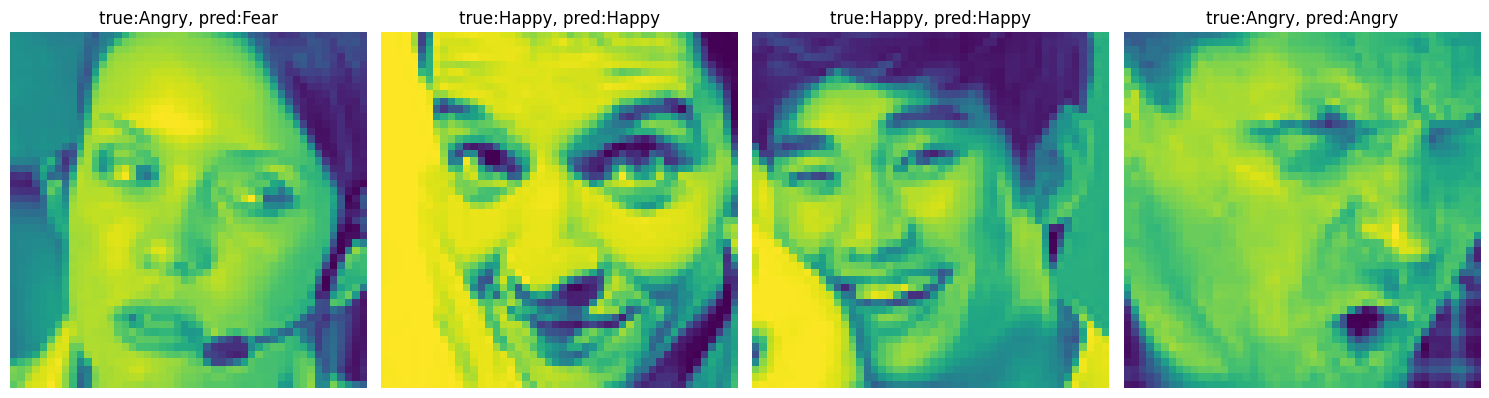

In [134]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, ax in enumerate(axes):
    image = image_batch[i]
    ax.imshow(image)
    ax.set_title(f'true:{emotion_map[label_batch[i]]}, pred:{emotion_map[label_batch_pred[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [135]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/File.zip'

In [136]:
with zipfile.ZipFile(path, 'r') as zip_ref:
  zip_ref.extractall('extracted/')

In [137]:
images = []

files_names = os.listdir('extracted/')
for file_name in files_names:
  image = cv2.imread(os.path.join('extracted', file_name), cv2.IMREAD_GRAYSCALE) # use this line if you want image channels number to be 1
  # image = cv2.imread(os.path.join('extracted', file_name), cv2.IMREAD_COLOR) # use this line if you want image channels number to be 3

  image = cv2.resize(image, (48, 48))
  image = image.astype('float32') / 255.0
  image = np.expand_dims(image, axis=-1) # use this line for one channeled images
  images.append(image)

In [138]:
images = np.array(images)
y_hat = np.argmax(model.predict(images), axis=1)

1/1 [==============================] - 0s 35ms/step


In [139]:
images.shape

(11, 48, 48, 1)

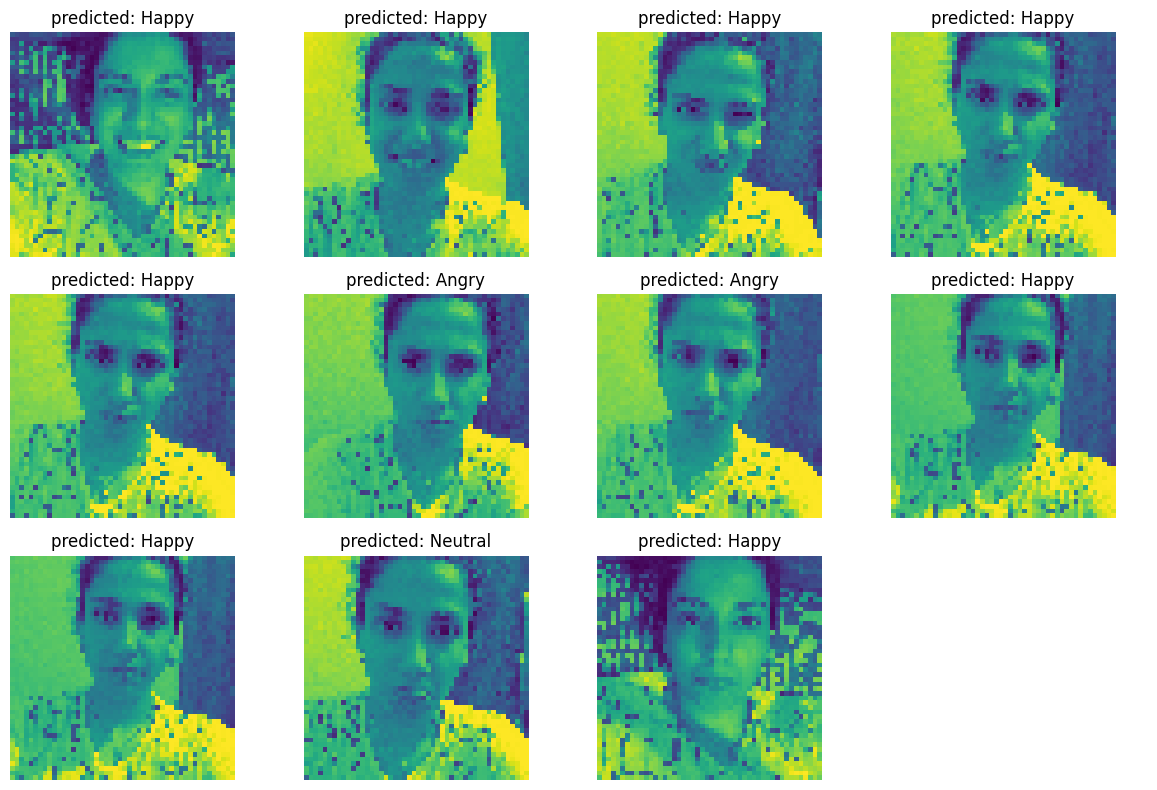

In [140]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i in range(3):
  for j in range(4):
    ax = axes[i][j]
    if i!=2 or j!=3:
      ax.imshow(images[i*3 + j])
      ax.set_title(f'predicted: {emotion_map[y_hat[i*3 + j]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()